<h3> Build a model on the upsampled dataset which includes all the positive class and 25K from the negative class

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
import missingno as msno
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, recall_score, precision_score
from datetime import timedelta
import itertools
%matplotlib inline

In [2]:
dataset = pd.read_csv('upsampled_data_50k.csv')
dataset.describe()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
count,5.000000e+04,27238.000000,27238.000000,27238.000000,27238.000000,27238.000000,27238.000000,27238.000000,27238.000000,27238.000000,...,1230.0,1230.000000,1230.000000,1230.000000,1230.000000,2373.000000,2373.000000,2373.000000,2373.000000,50000.000000
mean,1.193251e+06,0.000023,0.000941,-0.016480,-0.016235,0.001479,-0.001413,-0.000774,-0.005116,-0.004083,...,0.0,0.000011,0.000417,0.000060,-0.013415,-0.000008,0.000001,0.000026,0.000026,0.500000
std,6.828337e+05,0.079047,0.091700,0.206429,0.206439,0.094583,0.163655,0.018923,0.101620,0.114463,...,0.0,0.000399,0.006160,0.000718,0.249741,0.000108,0.000036,0.000475,0.000388,0.500005
min,8.600000e+01,-0.356000,-0.362000,-0.397000,-0.416000,-0.404000,-0.566000,-0.044000,-0.232000,-0.388000,...,0.0,0.000000,0.000000,0.000000,-0.250000,-0.001000,0.000000,0.000000,0.000000,0.000000
25%,6.077412e+05,-0.049000,-0.056000,-0.179000,-0.179000,-0.056000,-0.066000,-0.015000,-0.072000,-0.087000,...,0.0,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.193350e+06,0.003000,0.004000,-0.033000,-0.034000,0.031000,0.025000,-0.007000,-0.032000,-0.005000,...,0.0,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,1.786041e+06,0.056000,0.063000,0.003000,0.003000,0.074000,0.116000,0.015000,0.048000,0.071000,...,0.0,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.367316e+06,0.271000,0.272000,0.567000,0.566000,0.335000,0.252000,0.096000,0.488000,0.459000,...,0.0,0.014000,0.132000,0.020000,0.250000,0.002000,0.001000,0.019000,0.014000,1.000000


<h4> Visually look at this using Missingno. First create a label column and a features column

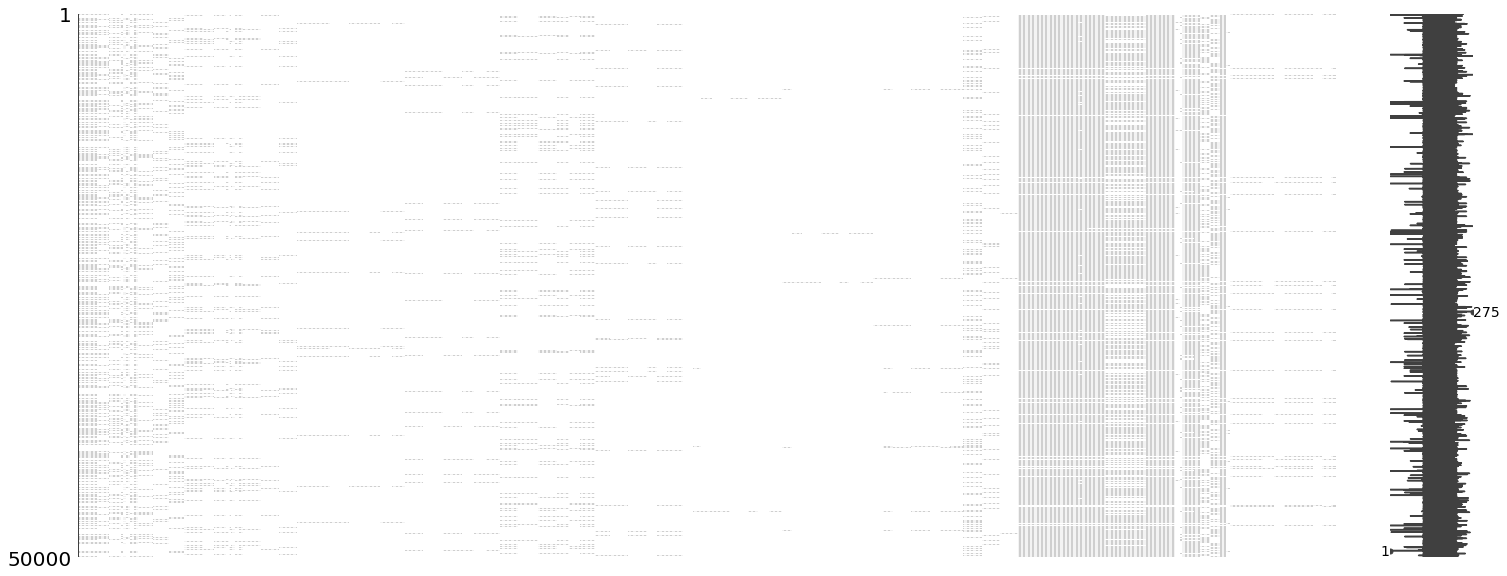

In [5]:
msno.matrix(dataset.drop(columns = ['Response']))

In [3]:
labels = dataset.Response
features = dataset.drop(columns=['Id', 'Response'])

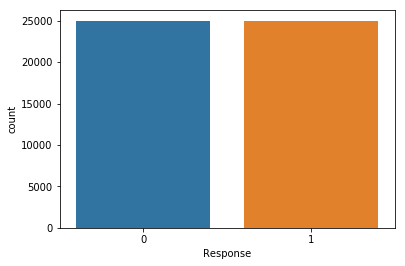

In [4]:
import seaborn as sns
sns.countplot(labels)

<h5> Next we drop columns that just don't have much data


In [6]:
def get_reduced_dataset(dataset, threshold):
    cols = dataset.columns
    size = dataset.shape
    reduced_dataset = pd.DataFrame()
    for i, col in enumerate(cols):
        if dataset[cols[i]].count()/size[0] < threshold:
            pass
        else:
            reduced_dataset[col] = dataset[cols[i]]
    return reduced_dataset       

In [7]:
# Threshold can be a parameter we play with later on. 
red_dataset = get_reduced_dataset(dataset, 0.5)

In [28]:
print("Original Dataset shape = {} becomes ------> Reduced Dataset shape = {}".format(dataset.shape, red_dataset.shape))

Original Dataset shape = (50000, 970) becomes ------> Reduced Dataset shape = (50000, 158)


<h4> Let's look at the reduced dataset using missingno to see if we dropped the right columns


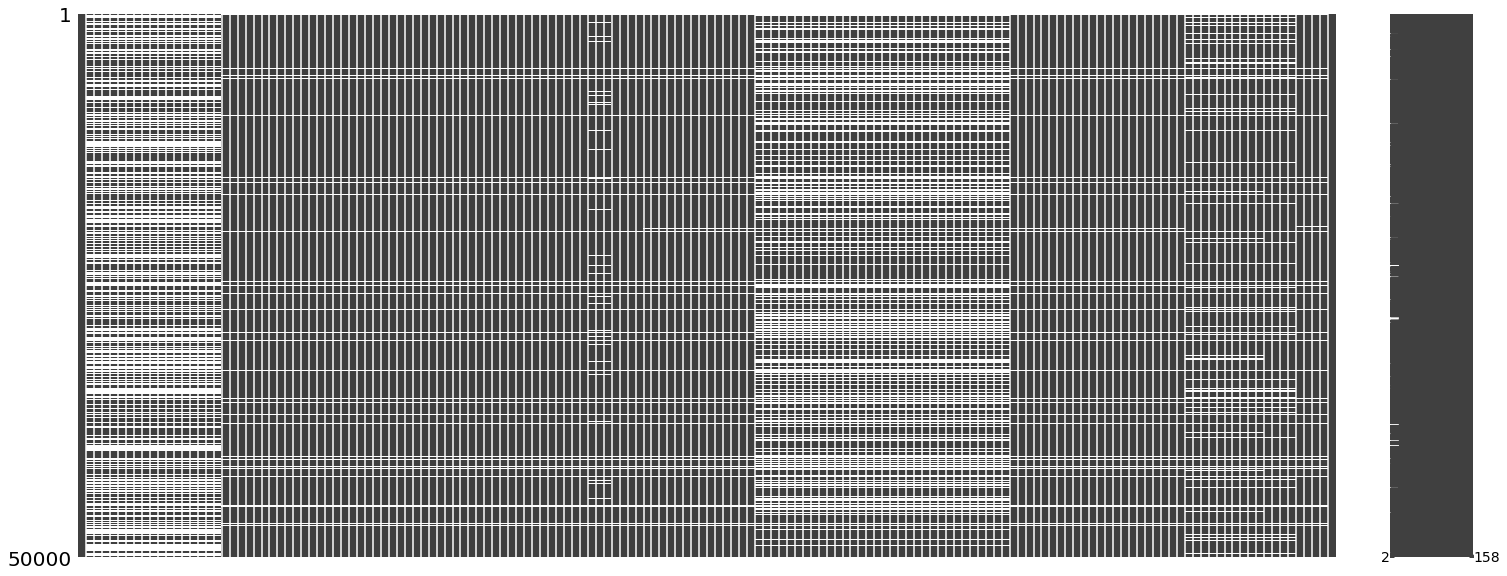

In [29]:
msno.matrix(red_dataset)

<h5> This is an extreme reduction - from 970 to roughly 150 features. Now we can look at the correlation matrix for the reduced dataset as well as how correlated the reduced labels are with the final response variable. 

In [10]:
final_labels = red_dataset.Response
final_features = red_dataset.drop(columns=['Id', 'Response'])
feature_names = final_features.columns

In [12]:
response_corr = red_dataset[red_dataset.columns[1:]].corr()['Response'][:-1]
resp_dict = dict(zip(np.abs(response_corr), feature_names))

<h6> Arrange the dict in terms of the highest and lowest values of the correlations

In [14]:
rev_dict = dict()
for num in sorted(resp_dict, reverse=True):
    rev_dict[resp_dict[num]] = num

<h4> Now we know the highest and lowest correlated features. Plot the top 10

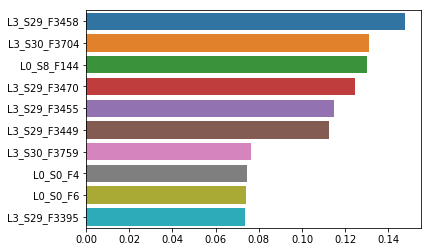

In [16]:
sns.barplot(x = list(rev_dict.values())[:10], y = list(rev_dict.keys())[:10])
plt.savefig('correlations.png')

<h3> Next we write the pipeline for Machine Learning

In [11]:
means = red_dataset.mean()
imputed_dataset = final_features.fillna(red_dataset.mean())
retained_columns = imputed_dataset.columns

<h6> All columns are now imputed with their corresponding means. Lets look at some histograms of the columns.

In [327]:
imputed_dataset.describe()

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S33_F3871,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,5.000000e+04,5.000000e+04,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000
mean,0.001378,0.002334,-0.024000,-0.024323,0.014918,0.010612,-0.003608,-0.017354,-0.004501,0.000156,...,0.000006,0.000034,2.400000e-07,2.400000e-07,0.000004,0.000072,1.400000e-07,0.000011,0.000028,0.000053
std,0.058361,0.067698,0.152582,0.152624,0.071340,0.121503,0.014307,0.076189,0.084483,0.082129,...,0.000299,0.001406,2.190781e-05,3.794695e-05,0.000241,0.003008,1.183145e-05,0.002313,0.001110,0.002784
min,-0.356000,-0.362000,-0.397000,-0.416000,-0.404000,-0.566000,-0.044000,-0.232000,-0.388000,-0.425000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,-0.003000,-0.004000,-0.052000,-0.052000,-0.013000,0.025000,-0.007000,-0.032000,-0.016000,-0.019000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,0.003000,0.004000,-0.033000,-0.034000,0.031000,0.025000,-0.007000,-0.032000,-0.005000,0.002000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,0.010000,0.011000,-0.033000,-0.034000,0.031000,0.070000,0.000000,-0.032000,0.005000,0.013000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
max,0.271000,0.272000,0.567000,0.566000,0.335000,0.252000,0.096000,0.488000,0.459000,0.436000,...,0.058000,0.146000,3.000000e-03,6.000000e-03,0.035000,0.478000,1.000000e-03,0.517000,0.066000,0.492000


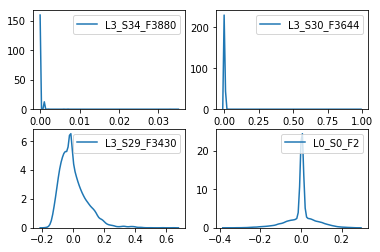

In [328]:
plt.figure()
plt.subplot(221)
sns.kdeplot(imputed_dataset[feature_names[150]])
plt.subplot(222)
sns.kdeplot(imputed_dataset[feature_names[100]])
plt.subplot(223)
sns.kdeplot(imputed_dataset[feature_names[50]])
plt.subplot(224)
sns.kdeplot(imputed_dataset[feature_names[1]])

,<h6> Some of the columns have considerable skew, which might affect the model. We can easily add a deskewing operator to convert thsse columns to their logged values if the kurtosis if sufficiently large. Also notice the difference in the absolute values of the numerical features. For this we introduce a Standard Scaler on the training data

In [448]:
def skew_eliminator(dataset, threshold):
    get_col_names = []
    kurt_vec = dataset.kurtosis()
    # if kurtosis is nan, drop that columns
    for i, cols in enumerate(dataset.columns):
        if np.isnan(kurt_vec[i]):
            dataset.drop(columns = cols)
        if kurt_vec[i] > threshold:
            dataset[cols] = np.log(dataset[cols]+1)
            get_col_names.append(cols)
            #[np.log(x+1) for x in dataset[[cols]]]
        else:
            pass
    return dataset, get_col_names

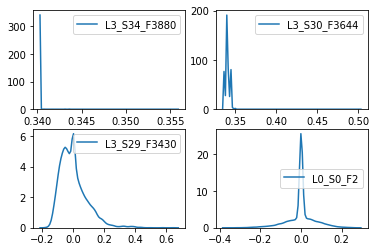

In [302]:
plt.figure()
plt.subplot(221)
sns.kdeplot(imputed_dataset_deskew[feature_names[150]])
plt.subplot(222)
sns.kdeplot(imputed_dataset_deskew[feature_names[100]])
plt.subplot(223)
sns.kdeplot(imputed_dataset_deskew[feature_names[50]])
plt.subplot(224)
sns.kdeplot(imputed_dataset_deskew[feature_names[1]])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(imputed_dataset, labels, test_size = 0.2)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
#X_train_scaled_deskewed = skew_eliminator(pd.DataFrame(X_train_scaled), 10)[0]
#print("Min, Max Kurtosis before scaling --{}, {}".format(np.min(imputed_dataset.kurtosis())
#                                                        ,np.max(imputed_dataset.kurtosis())))
#print("Min, Max Kurtosis after scaling --{}, {}".format(np.min(X_train_scaled_deskewed.kurtosis())
#                                                        ,np.max(X_train_scaled_deskewed.kurtosis())))

In [450]:
#cols_to_skew = skew_eliminator(pd.DataFrame(X_train_scaled), 10)[1]

In [20]:
#len(cols_to_skew)

In [17]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve, recall_score, precision_score

In [22]:
model_rf = RandomForestClassifier(min_samples_leaf=1, n_estimators=500, max_depth = 16)
model_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [387]:
# Run a GridSearch
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 4, 8, 16],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1, 10, 100, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'recall'
                          )

grid_search.fit(X_train_scaled_deskewed, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  5.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [2, 4, 8, 16], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [8, 10, 12], 'n_estimators': [1, 10, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

In [404]:
best_est = grid_search.best_estimator_
grid_search.best_score_

0.8647024203247143

In [23]:
#X_test_scaled = skew_eliminator(pd.DataFrame(X_test_scaled), 10)
pred = model_rf.predict(X_test_scaled)
train_pred = model_rf.predict(X_train_scaled)
print("Val accuracy  = {}, Train accuracy = {}".format(accuracy_score(y_test, pred), accuracy_score(y_train, train_pred)))

Val accuracy  = 0.9102, Train accuracy = 0.9736


In [24]:
#confusion_matrix(y_test, pred)
recall_score(y_test, pred), precision_score(y_test, pred)

(0.9246492985971944, 0.8983644859813084)

In [402]:
X_test_scaled_deskewed = skew_eliminator(pd.DataFrame(X_test_scaled), 10)
pred = best_est.predict(X_test_scaled_deskewed)
train_pred = best_est.predict(X_train_scaled_deskewed)
print("Val accuracy  = {}, Train accuracy = {}".format(accuracy_score(y_test, pred), accuracy_score(y_train, train_pred)))

Val accuracy  = 0.7416, Train accuracy = 0.9737


In [393]:
accuracy_score(y_train, train_pred)

0.9737

In [411]:
#accuracy_score(y_test, pred)
recall_score(y_test, pred), precision_score(y_test, pred)

0.8720508166969148

In [25]:
confusion_matrix(y_test, pred)

array([[4488,  522],
       [ 376, 4614]])

In [27]:
pred_proba_rf = model_rf.predict_log_proba(X_test_scaled)
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_proba_rf[:, 1])
area_rf = auc(fpr_rf, tpr_rf)

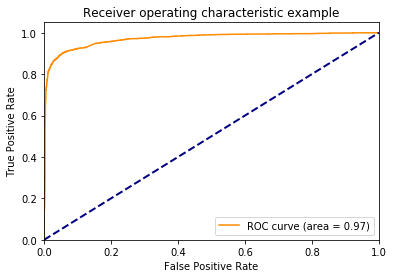

In [30]:
lw = 2
plt.plot(fpr_rf, tpr_rf, color='darkorange',
          label='ROC curve (area = %0.2f)' % area_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<h5> The upsampled model outperforms the baseline and has a extremely high recall on the holdout. 

In [31]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(penalty = 'l1')
model_lr.fit(X_train_scaled, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [420]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.1, 1, 10]
}
# Create a based model
logreg = LogisticRegression()
# Instantiate the grid search model
lr_grid_search = GridSearchCV(estimator = logreg, param_grid = param_grid, 
                          cv = 3, n_jobs = 3, verbose = 2, scoring = 'recall'
                          )

lr_grid_search.fit(X_train_scaled_deskewed, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed: 11.8min finished
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=2)

In [33]:
pred = model_lr.predict(X_test_scaled)
train_pred = model_lr.predict(X_train_scaled)
print("Training Accuracy = {:.2f}".format(accuracy_score(y_train, train_pred)))
print("Validation Accuracy = {:.2f}".format(accuracy_score(y_test, pred)))

Training Accuracy = 0.60
Validation Accuracy = 0.60


In [423]:
best_lr = lr_grid_search.best_estimator_
pred = best_lr.predict(X_test_scaled_deskewed)
train_pred = best_lr.predict(X_train_scaled_deskewed)
print("Training Accuracy = {:.2f}".format(accuracy_score(y_train, train_pred)))
print("Validation Accuracy = {:.2f}".format(accuracy_score(y_test, pred)))

Training Accuracy = 0.59
Validation Accuracy = 0.59


In [443]:
best_lr

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
pred_proba_lr = model_lr.predict_log_proba(X_test_scaled)
fpr_lr, tpr_lr, _ = roc_curve(y_test, pred_proba_lr[:, 1])
area_lr = auc(fpr_lr, tpr_lr)

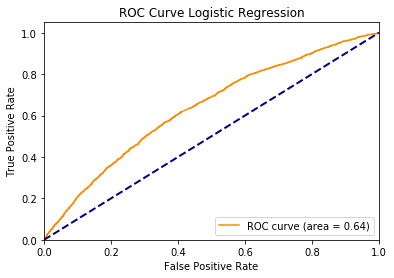

In [38]:
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange',
          label='ROC curve (area = %0.2f)' % area_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [39]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [428]:
y_pred_nb = gnb.fit(X_train_scaled_deskewed, y_train).predict(X_test_scaled_deskewed)
accuracy_score(y_test, y_pred_nb)

0.4956

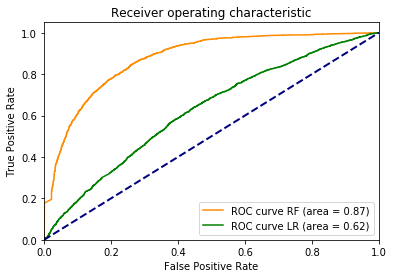

In [434]:
lw = 2
plt.plot(fpr_rf, tpr_rf, color='darkorange',
          label='ROC curve RF (area = %0.2f)' % area_rf)
plt.plot(fpr_lr, tpr_lr, color='green',
          label='ROC curve LR (area = %0.2f)' % area_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [40]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
y_pred_nb = xgb.fit(X_train_scaled, y_train).predict(X_test_scaled)
accuracy_score(y_test, y_pred_nb)

0.6639

In [41]:
pred_proba_xg = xgb.predict_proba(X_test_scaled)
fpr_xg, tpr_xg, _ = roc_curve(y_test, pred_proba_xg[:, 1])
area_xg = auc(fpr_xg, tpr_xg)

In [442]:
param_grid = {
    'eta': [0.01, 0.1, 1],
    'max_depth': [2, 4, 8, 16],
    'lambda': [0.1, 1, 5],
    'min_child_weight': [1, 5, 10]
}
# Create a based model
# Instantiate the grid search model
grid_search_xgb = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'recall'
                          )

grid_search_xgb.fit(X_train_scaled_deskewed, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min


KeyboardInterrupt: 

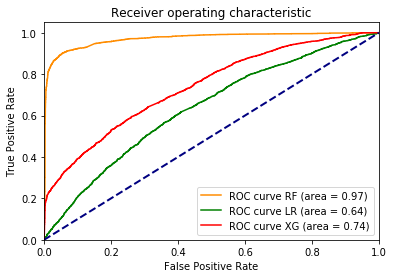

In [43]:
lw = 2
plt.plot(fpr_rf, tpr_rf, color='darkorange',
          label='ROC curve RF (area = %0.2f)' % area_rf)
plt.plot(fpr_lr, tpr_lr, color='green',
          label='ROC curve LR (area = %0.2f)' % area_lr)
plt.plot(fpr_xg, tpr_xg, color='red',
          label='ROC curve XG (area = %0.2f)' % area_xg)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Model_comparison.png')
plt.show()

<h2> Test Data PreProcessing: Ensure test data runs through same pre-processing pipeline as training data

<h5> Pickle the colnames_to_keep, Means of the training data columns, the scaler, and columns_to_skew

In [45]:
import pickle
to_pickle = [retained_columns, means, scaler]
with open('preprocessing_Bosch.pickle', 'wb') as f1:
    pickle.dump(to_pickle, f1)

In [46]:
with open('preprocessing_Bosch.pickle', 'rb') as f1:
    params = pickle.load(f1)

In [50]:
#test_data = pd.read_csv('FInal_Numeric_Datsets/shuffled_train_numeric_test.csv', usecols = ['Response'])

In [52]:
#test_data

In [53]:
def preprocess_dataset(datapath, colnames_to_keep, means, scaler):
    ''' Preprocess any new data to match the training dataset'''
    # Just get the required columns
    
    dataset = pd.read_csv(datapath)
    labels = dataset['Response']
    dataset = dataset[colnames_to_keep]
    
    
    print(dataset.shape)
    
    #for column in list(dataset.columns):
    #    dataset[column] = dataset[column].astype('float32')

    #Impute with means
    dataset = dataset.fillna(means)
    
    #Scale
    scaled_dataset = pd.DataFrame(scaler.transform(dataset))
    
    #DeSkew
    #for colname in scaled_dataset.columns:
    #    if colname in colnames_to_skew:
    #        scaled_dataset[colname] = np.log(scaled_dataset[colname]+ 1)
    #    else:
    #        pass
    
    return scaled_dataset, labels    

In [54]:
test_data = preprocess_dataset('FInal_Numeric_Datsets/shuffled_train_numeric_test.csv', list(params[0]), params[1], params[2])

(200000, 156)


In [55]:
lr_test_pred = model_lr.predict(test_data[0])
print("Test Accuracy = {:.2f}".format(accuracy_score(test_data[1], lr_test_pred)))

Test Accuracy = 0.57


In [56]:
rf_test_pred = model_rf.predict(test_data[0])
print("Test Accuracy = {:.2f}".format(accuracy_score(test_data[1], rf_test_pred)))

Test Accuracy = 0.90


In [60]:
#xgb_test_pred = xgb.predict(test_data[0])
#print("Test Accuracy = {:.2f}".format(accuracy_score(test_data[1], xgb_test_pred)))

In [80]:
cfmat = confusion_matrix(test_data[1], rf_test_pred)

In [76]:
cfmat

array([[8.9641e-01, 9.7480e-02],
       [5.4000e-04, 5.5700e-03]])

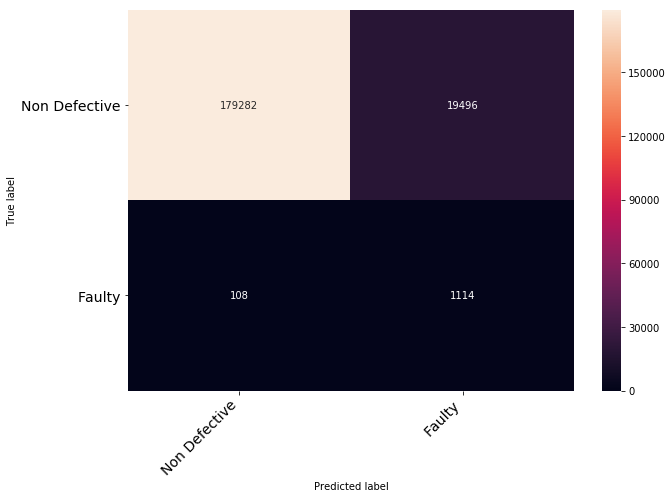

In [83]:
class_names = ['Non Defective', 'Faulty']
fontsize = 14
df_cm = pd.DataFrame(
        cfmat, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize = (10,7))
heatmap = sns.heatmap(df_cm, annot=True,
                     fmt = 'd')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')
plt.show()

In [63]:
recall_score(test_data[1], rf_test_pred), precision_score(test_data[1], rf_test_pred)

(0.911620294599018, 0.054051431344007764)

In [66]:
1114+108

1222

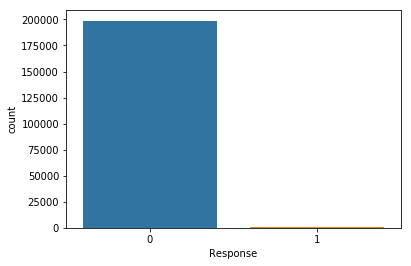

In [64]:
sns.countplot(test_data[1])

<h3> To get better accuracy, we need more data. Let's take the entire dataset and write a pipeline to randomly generate a 10 files of size 50K each with 25K positive and 25K negative examples.

In [381]:
#import os
#from sklearn.utils import resample, shuffle
#data_path = os.getcwd() + '/train_data/shuffled_train_numeric.csv'
#def get_sharded_datasets(full_data_path):
#    chunksize = 100000
#    for i, chunk in enumerate(pd.read_csv(data_path, chunksize=chunksize)):
#            temp_df = chunk[chunk['Response'] == 1]
#            neg_df = chunk[chunk['Response']==0][:25000]
#            pos_df = resample(temp_df, n_samples=25000,random_state=42,replace=True)
#            full_df = shuffle(pd.concat([neg_df, pos_df]), random_state = 42)
#            print("Chunk Number: {}".format(i))
#            full_df.to_csv(os.path.dirname(full_data_path) + "/upsampled_data_50k_{}.csv".format(i))
#    return print("Done")   

In [1]:
#os.path.dirname(data_path) + "/upsampled_data_50k_{}.csv".format(1)
#get_sharded_datasets(data_path)